## Import the packages and function

In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
import keras.backend as k
from keras.optimizers import RMSprop 

import matplotlib.pyplot as plt

from sklearn.utils import shuffle

Using TensorFlow backend.


## Load Data (Old)

In [29]:
del fruit_x
del fruit_y

In [30]:
fruit_x=[]
fruit_y=[]

# labels =['Apple', 'Avocado','Cherry','Kiwi','Kumquats', 'Lemon']

# path = '.\\Training'
# path = '.\\SamllTrain'
# path = '.\\SamllTrain_50'
path = '.\\LessImageTrain'
labels = listdir(path)

for labelName in labels:
    file_path = join(path,labelName)
    image_names = listdir(file_path)
    for aimage in image_names:
        image_path = join(file_path,aimage)
#         if(os.path.exists(image_path)):
#         train_image = load_img(image_path,color_mode = "grayscale")  # GrayScale
        train_image = load_img(image_path)  # RGB Image

        train_image = img_to_array(train_image)  # this is a Numpy array with shape (3, 150, 150)
        fruit_x.append(train_image)
        fruit_y.append(labelName)
        
fruit_x_ori= fruit_x.copy()
fruit_y_ori= fruit_y.copy()

In [31]:
len(fruit_x)

4000

### Data preprocessing

In [33]:
if 'fruit_x' in locals():
    del fruit_x
if 'fruit_y' in locals():
    del fruit_y
    
fruit_x= fruit_x_ori
fruit_y= fruit_y_ori

fruit_x = np.asarray(fruit_x)/255

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(fruit_y)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
fruit_y = onehot_encoder.fit_transform(integer_encoded)

num_class = len(labels)
input_shape = fruit_x[0].shape

# X_train, X_test, Y_train, Y_test = train_test_split(fruit_x, fruit_y, test_size=0.2,shuffle = True,random_state=1)
X_train, X_test, Y_train, Y_test = train_test_split(fruit_x, fruit_y, test_size=0.2,shuffle = True)
# X_train = np.asarray(X_train)
# X_test = np.asarray(X_test)

# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# X_train /= 255
# X_test /= 255

In [35]:
# input_shape
len(X_train)
# X_train

3200

In [40]:
# X_train, X_test, Y_train, Y_test = train_test_split(fruit_x, fruit_y, test_size=0.2,shuffle = True,random_state=1)
X_train, X_test, Y_train, Y_test = train_test_split(fruit_x, fruit_y, test_size=0.3,shuffle = True)

In [15]:
X_train=[]
Y_train=[]

path_train = '.\\LessImageTrain'
labels = listdir(path_train)

for labelName in labels:
    file_path = join(path_train,labelName)
    image_names = listdir(file_path)
    for aimage in image_names:
        image_path = join(file_path,aimage)
        train_image = load_img(image_path)  # RGB Image

        train_image = img_to_array(train_image)  # this is a Numpy array with shape (3, 150, 150)
        X_train.append(train_image)
        Y_train.append(labelName)

X_test=[]
Y_test=[]
path_test = '.\\LessImageTest'
labels = listdir(path_train)
for labelName in labels:
    file_path = join(path_test,labelName)
    image_names = listdir(file_path)
    for aimage in image_names:
        image_path = join(file_path,aimage)
        train_image = load_img(image_path)  # RGB Image

        train_image = img_to_array(train_image)  # this is a Numpy array with shape (3, 150, 150)
        X_test.append(train_image)
        Y_test.append(labelName)        

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y_train)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y_train = onehot_encoder.fit_transform(integer_encoded)

integer_encoded = label_encoder.fit_transform(Y_test)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y_test = onehot_encoder.fit_transform(integer_encoded)


num_class = len(labels)
input_shape = X_train[0].shape

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

len(X_test)

810

### Build the InceptionV3 Model(Keras) Function

In [5]:
# create the base pre-trained model
def build_model(nb_classes, inputs_shape):
    k.clear_session()
    base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=inputs_shape)
    
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
#     x = Dropout(0.5)(x)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers[:249]:
        layer.trainable = False
    for layer in base_model.layers[249:]:
        layer.trainable = True
    count = 0
    for layer in base_model.layers:
        if ('batch_normalization' in layer.name):
            count +=1
            layer.trainable =True
            if(count>=19):
                break
        
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # compile the model (should be done *after* setting layers to non-trainable)
    print ("starting model compile")
    compile(model)
    print ("model compile done")
    return model

def compile(model):
    model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=["accuracy"])    

### Train and evaluate

In [6]:
model = build_model(num_class, input_shape)
# model = build_model(81, [100,100,3])
# # model.summary()
# print("\n===============================\n The trainable layers:")
# for layer in model.trainable_weights:
#     print(layer.name)

starting model compile
model compile done


In [7]:
len(model.trainable_weights)

59

In [9]:
# epochs = 30
epochs = 5
batch_size = 100

history=model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 5083 samples, validate on 1017 samples
Epoch 1/5
5083/5083 [==============================] - 364s 72ms/step - loss: 0.0317 - accuracy: 0.9982 - val_loss: 3.9498 - val_accuracy: 0.6067
Epoch 2/5
5083/5083 [==============================] - 364s 72ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 3.1317 - val_accuracy: 0.6431
Epoch 3/5
5083/5083 [==============================] - 359s 71ms/step - loss: 3.6843e-06 - accuracy: 1.0000 - val_loss: 3.5866 - val_accuracy: 0.6382
Epoch 4/5
5083/5083 [==============================] - 360s 71ms/step - loss: 0.0108 - accuracy: 0.9986 - val_loss: 2.3622 - val_accuracy: 0.6804
Epoch 5/5
5083/5083 [==============================] - 360s 71ms/step - loss: 0.0776 - accuracy: 0.9990 - val_loss: 2.5933 - val_accuracy: 0.7522
Test loss: 2.5932667785220676
Test accuracy: 0.752212405204773


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


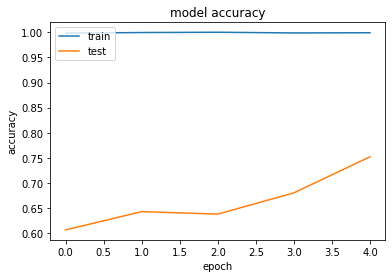

In [10]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# plt.plot(history.history['loss'])
# plt.title('Loss')
# plt.ylabel('Loss')
# plt.xlabel('epoch')


In [11]:
# # save(model, 'model_100images')
# # model.save('model_Allimages.h5')
# model.save('model_300images.h5')
# model.save('./ModelBox/model_SamllTrain.h5')
# model.save('./ModelBox/Fruit_3Classes.h5')
model.save('./ModelBox/Fruit_10Classes.h5')

In [13]:
# from keras.preprocessing.image import array_to_img

# X_train[0]*=255
# X_train[0]
# array_to_img(X_train[100]*255)
# len(X_train)
model.evaluate(X_train, Y_train, verbose=0)


[2.735868464814568, 0.7509344816207886]

#### BackUp codes

In [45]:
X_test=[]
Y_test=[]
path_test = '.\\LessImageTest'
labels = listdir(path_train)
for labelName in labels:
    file_path = join(path_test,labelName)
    image_names = listdir(file_path)
    for aimage in image_names:
        image_path = join(file_path,aimage)
        train_image = load_img(image_path)  # RGB Image

        train_image = img_to_array(train_image)  # this is a Numpy array with shape (3, 150, 150)
        X_test.append(train_image)
        Y_test.append(labelName)        

integer_encoded = label_encoder.fit_transform(Y_test)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y_test = onehot_encoder.fit_transform(integer_encoded)

X_test = np.asarray(X_test)
X_test = X_test.astype('float32')
X_test /= 255

len(X_test)

810

In [ ]:
# base_model = InceptionV3(weights='imagenet', include_top=False)

# # add a global spatial average pooling layer
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # let's add a fully-connected layer
# x = Dense(1024, activation='relu')(x)
# # and a logistic layer -- let's say we have 200 classes
# predictions = Dense(6, activation='softmax')(x)

# # this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)

# # first: train only the top layers (which were randomly initialized)
# # i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False

# # compile the model (should be done *after* setting layers to non-trainable)
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# # train the model on the new data for a few epochs
# model.fit_generator(...)

# # at this point, the top layers are well trained and we can start fine-tuning
# # convolutional layers from inception V3. We will freeze the bottom N layers
# # and train the remaining top layers.

# # let's visualize layer names and layer indices to see how many layers
# # we should freeze:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

# # we chose to train the top 2 inception blocks, i.e. we will freeze
# # the first 249 layers and unfreeze the rest:
# for layer in model.layers[:249]:
#    layer.trainable = False
# for layer in model.layers[249:]:
#    layer.trainable = True

# # we need to recompile the model for these modifications to take effect
# # we use SGD with a low learning rate
# from keras.optimizers import SGD
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# # we train our model again (this time fine-tuning the top 2 inception blocks
# # alongside the top Dense layers
# model.fit_generator(...)

### Extract Images from original data

In [ ]:
import os
import shutil

path = '.\\Training'
smallPath = '.\\LessImageTrain'
labels_list = listdir(path)

for labelName in labels_list:
    tmp_path = join(smallPath,labelName)
    if(not os.path.exists( tmp_path)):
        os.mkdir(tmp_path)

    ori_path = join(path,labelName)
    new_path = join(smallPath,labelName)
    
    image_names = listdir(ori_path)
    image_num =0
    
    randonIndex =  np.random.choice(len(image_names),200, replace=False)
    for ind in randonIndex:
        image_num +=1
        shutil.copyfile(join(ori_path,image_names[ind]),join(new_path,image_names[ind]))
    
    
#     for ind in range(0,len(image_names),5):
#         image_num +=1
#         shutil.copyfile(join(ori_path,image_names[ind]),join(new_path,image_names[ind]))
#         if(image_num==100):
#             break

# labels_list

# Read partial categories

In [12]:
if 'X_train' in locals():
    del X_train
if 'Y_train' in locals():
    del Y_train
if 'X_test' in locals():
    del X_test
if 'Y_test' in locals():
    del Y_test
if 'model' in locals():
    del model


In [2]:
X_train=[]
Y_train=[]

# path_train = '.\\LatestData\Training'
path_train = '.\\Fruits\\Training'
labels = listdir(path_train)

num_class = 10

randonIndex =  np.random.choice(len(labels),num_class, replace=False)

for index in randonIndex:
    file_path = join(path_train,labels[index])
    image_names = listdir(file_path)
    for aimage in image_names:
        image_path = join(file_path,aimage)
        train_image = load_img(image_path)  # RGB Image

        train_image = img_to_array(train_image)  # this is a Numpy array with shape (3, 150, 150)
        X_train.append(train_image)
        Y_train.append(labels[index])

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y_train)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y_train = onehot_encoder.fit_transform(integer_encoded)


# num_class = len(labels)
input_shape = X_train[0].shape

X_train = np.asarray(X_train)

X_train = X_train.astype('float32')
X_train /= 255

_, X_test, _, Y_test = train_test_split(X_train, Y_train, test_size=0.2,shuffle = True)

X_train,Y_train=shuffle(X_train,Y_train)

In [12]:
randonIndex

array([71, 14,  3, 23, 25, 73, 62, 41, 16, 11])

In [3]:
# len(X_train)
X_train,Y_train=shuffle(X_train,Y_train)